In [1]:
#Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# **Step -01: Exploratory Data Analysis (EDA)**

In [2]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/train.csv")

In [3]:
print(df.shape)

(12120, 6)


In [4]:
df.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [5]:
df.isnull().sum()

,0
id,0
premise,0
hypothesis,0
lang_abv,0
language,0
label,0


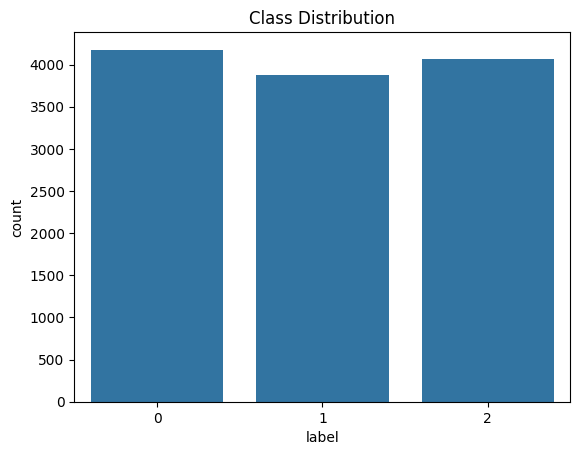

In [6]:
sns.countplot(x=df['label'])
plt.title("Class Distribution")
plt.show()

# Step 2: Text Preprocessing


In [9]:
from nltk.stem import SnowballStemmer

In [19]:
# Download required NLTK resources
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [11]:
# Define stopwords and stemmers for supported languages
supported_languages = {
    "en": "english",
    "fr": "french",
    "de": "german",
    "es": "spanish",
    "ru": "russian",
    "bg": "bulgarian",
    "el": "greek",
}

In [12]:
# Languages that have stopwords but no stemming support
stopword_only_languages = {"tr"}  # Turkish doesn't have stemming support in NLTK

In [13]:
# Languages without stopword lists or stemming support (basic cleaning only)
unsupported_languages = {"zh", "ar", "sw", "ur", "vi", "hi", "th"}

In [15]:
# Load stopwords and stemmers (skip missing stopwords)
language_tools = {}
for lang_abv, lang_name in supported_languages.items():
    try:
        stop_words = set(stopwords.words(lang_name))
    except OSError:
        print(f"Warning: No stopwords available for {lang_name}. Skipping stopword removal.")
        stop_words = set()  # No stopwords available

    try:
        stemmer = SnowballStemmer(lang_name)
    except ValueError:
        print(f"Warning: No stemming available for {lang_name}. Using stopwords only.")
        stemmer = None  # No stemming available

    language_tools[lang_abv] = {"stopwords": stop_words, "stemmer": stemmer}

In [16]:
# Function to preprocess text based on language abbreviation
def preprocess_text(text, lang_abv):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\u0400-\u04FF\u0E00-\u0E7F\u0600-\u06FF\s]', '', text)  # Keep multilingual characters
    tokens = word_tokenize(text)

    if lang_abv in language_tools:
        stop_words = language_tools[lang_abv]["stopwords"]
        stemmer = language_tools[lang_abv]["stemmer"]
        tokens = [stemmer.stem(word) if stemmer else word for word in tokens if word not in stop_words]

    elif lang_abv in stopword_only_languages:
        tokens = [word for word in tokens if word not in stopwords.words("turkish")]

    elif lang_abv in unsupported_languages:
        tokens = [word for word in tokens if len(word) > 1]  # Keep words longer than 1 character

    return " ".join(tokens)

In [20]:
# Apply preprocessing based on `lang_abv`
df["premise"] = df.apply(lambda row: preprocess_text(row["premise"], row["lang_abv"]), axis=1)
df["hypothesis"] = df.apply(lambda row: preprocess_text(row["hypothesis"], row["lang_abv"]), axis=1)

In [21]:
# Save the processed file
df.to_csv("train_preprocessed.csv", index=False)

# Step 3: Feature Extraction
 Implementation (XLM-R Feature Extraction)

In [22]:
from transformers import AutoTokenizer, AutoModel

In [23]:
# Load preprocessed dataset
df = pd.read_csv("train_preprocessed.csv")

In [27]:
# Load XLM-R tokenizer & model
xlmr_model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)
model = AutoModel.from_pretrained(xlmr_model_name)

In [28]:
# Function to generate XLM-R embeddings
def get_xlmr_embeddings(text):
    if not isinstance(text, str) or text.strip() == "":
        return np.zeros(768)  # Return zero vector for missing values

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)

    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()  # CLS token embedding

In [29]:
# Apply embeddings to premise & hypothesis
df["premise_embedding"] = df["premise"].astype(str).apply(get_xlmr_embeddings)
df["hypothesis_embedding"] = df["hypothesis"].astype(str).apply(get_xlmr_embeddings)

In [30]:
# Save embeddings
df.to_pickle("train_embeddings.pkl")

# Step 3: Model Creation

In [31]:
# Load processed embeddings
df = pd.read_pickle("train_embeddings.pkl")

In [32]:
# Convert embeddings from numpy arrays to list format
df["premise_embedding"] = df["premise_embedding"].apply(lambda x: np.array(x))
df["hypothesis_embedding"] = df["hypothesis_embedding"].apply(lambda x: np.array(x))

In [33]:
# Concatenate premise and hypothesis embeddings to form input features
df["features"] = df.apply(lambda row: np.concatenate((row["premise_embedding"], row["hypothesis_embedding"])), axis=1)

In [34]:
# Extract features (X) and labels (y)
X = np.vstack(df["features"].values)  # Convert list of arrays into a 2D NumPy array
y = df["label"].values  # Target labels

In [35]:
# Train-Validation-Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [36]:
print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")

Training Set: (9696, 1536), Validation Set: (1212, 1536), Test Set: (1212, 1536)


# Baseline Model: Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [38]:
# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [39]:
# Predictions
y_pred = rf_model.predict(X_val)

In [40]:
# Evaluation
print("Random Forest Model Performance:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Validation Accuracy:", accuracy_score(y_val, y_pred))

Random Forest Model Performance:
              precision    recall  f1-score   support

           0       0.29      0.37      0.32       417
           1       0.32      0.24      0.27       388
           2       0.29      0.27      0.28       407

    accuracy                           0.29      1212
   macro avg       0.30      0.29      0.29      1212
weighted avg       0.30      0.29      0.29      1212

Confusion Matrix:
 [[153 116 148]
 [170  94 124]
 [211  86 110]]
Validation Accuracy: 0.29455445544554454


In [86]:
best_rf_acc = 0
best_rf_params = None

for n_estimators in [100, 200]:
    for max_depth in [10, 20]:
        rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        rf_model.fit(X_train, y_train)

        y_pred_rf = rf_model.predict(X_train)
        acc_rf = accuracy_score(y_test, y_pred)

        if acc_rf > best_rf_acc:
            best_rf_acc = acc_rf
            best_rf_params = {"n_estimators": n_estimators, "max_depth": max_depth}

print(f"Best RF Params: {best_rf_params}, Accuracy: {best_rf_acc:.2f}")


Best RF Params: {'n_estimators': 100, 'max_depth': 10}, Accuracy: 0.34


# Neural Network (ANN)

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [47]:
# Define ANN model
ann_model = Sequential([
    Dense(512, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dense(3, activation="softmax")  # 3 output classes
])

In [48]:
# Compile the model
ann_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [49]:
# Train the model
ann_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.3347 - loss: 1.1360 - val_accuracy: 0.3383 - val_loss: 1.0983
Epoch 2/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.3380 - loss: 1.1018 - val_accuracy: 0.3383 - val_loss: 1.0981
Epoch 3/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.3449 - loss: 1.0985 - val_accuracy: 0.3441 - val_loss: 1.0985
Epoch 4/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.3509 - loss: 1.0984 - val_accuracy: 0.3531 - val_loss: 1.0982
Epoch 5/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.3466 - loss: 1.0981 - val_accuracy: 0.3441 - val_loss: 1.0983
Epoch 6/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.3481 - loss: 1.0982 - val_accuracy: 0.3441 - val_loss: 1.0982
Epoch 7/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.3500 - loss: 1.0979 - val_accuracy: 0.3350 - val_loss: 1.0982
Epoch 8/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.3441 - loss: 1.0981 - val_accu

In [50]:
# Evaluate on test set
test_loss, test_acc = ann_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3428 - loss: 1.0993
Test Accuracy: 0.3556


In [80]:
# Predict ANN
y_pred_ann = np.argmax(ann_model.predict(X_train), axis=1)

303/303 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


In [81]:
# Evaluate ANN Model
acc_ann = accuracy_score(y_train, y_pred_ann)
prec_ann, rec_ann, f1_ann, _ = precision_recall_fscore_support(y_train, y_pred_ann, average='weighted')

print("\nANN Model Evaluation:")
print(f"Accuracy: {acc_ann:.4f}")
print(f"Precision: {prec_ann:.4f}")
print(f"Recall: {rec_ann:.4f}")
print(f"F1-score: {f1_ann:.4f}")


ANN Model Evaluation:
Accuracy: 0.3478
Precision: 0.2432
Recall: 0.3478
F1-score: 0.2156


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


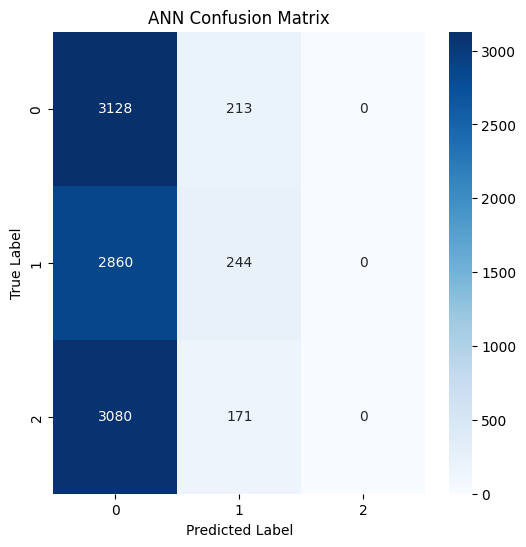

In [82]:
# Confusion Matrix for ANN
plt.figure(figsize=(6,6))
cm_ann = confusion_matrix(y_train, y_pred_ann)
sns.heatmap(cm_ann, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("ANN Confusion Matrix")
plt.show()

In [84]:
from tensorflow.keras.optimizers import Adam

best_ann_acc = 0
best_ann_params = None

for lr in [0.01, 0.001]:
    for dropout_rate in [0.3, 0.5]:
        ann_model = Sequential([
            Dense(512, activation="relu", input_shape=(X_train.shape[1],)),
            Dropout(dropout_rate),
            Dense(256, activation="relu"),
            Dropout(dropout_rate),
            Dense(128, activation="relu"),
            Dense(3, activation="softmax")
        ])

        ann_model.compile(optimizer=Adam(lr), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
        ann_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

        y_pred_ann = np.argmax(ann_model.predict(X_train), axis=1)
        acc_ann = accuracy_score(y_train, y_pred_ann)

        if acc_ann > best_ann_acc:
            best_ann_acc = acc_ann
            best_ann_params = {"lr": lr, "dropout": dropout_rate}

print(f"Best ANN Params: {best_ann_params}, Accuracy: {best_ann_acc:.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
303/303 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.3334 - loss: 1.3032
Epoch 2/5
303/303 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.3446 - loss: 1.0985
Epoch 3/5
303/303 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.3439 - loss: 1.0983
Epoch 4/5
303/303 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.3311 - loss: 1.0990
Epoch 5/5
303/303 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.3525 - loss: 1.0980
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
303/303 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.3387 - loss: 1.3089
Epoch 2/5
303/303 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.3386 - loss: 1.0997
Epoch 3/5
303/303 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.3389 - loss: 1.0995
Epoch 4/5
303/303 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.3252 - loss: 1.0992
Epoch 5/5
303/303 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.3438 - loss: 1.0984
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


303/303 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.3279 - loss: 1.1467
Epoch 2/5
303/303 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.3430 - loss: 1.1010
Epoch 3/5
303/303 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.3496 - loss: 1.0996
Epoch 4/5
303/303 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.3459 - loss: 1.0986
Epoch 5/5
303/303 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.3322 - loss: 1.0984
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
303/303 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.3318 - loss: 1.1569
Epoch 2/5
303/303 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.3284 - loss: 1.1031
Epoch 3/5
303/303 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.3239 - loss: 1.0997
Epoch 4/5
303/303 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.3474 - loss: 1.0979
Epoch 5/5
303/303 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.3413 - loss: 1.0984
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Best ANN Params: {'lr': 0.001, 'dropout': 0.3}, Accuracy: 0.34


# LSTM Model

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [52]:
# Load preprocessed embeddings
df = pd.read_pickle("train_embeddings.pkl")

In [53]:
# Convert embeddings to numpy arrays
df["premise_embedding"] = df["premise_embedding"].apply(lambda x: np.array(x))
df["hypothesis_embedding"] = df["hypothesis_embedding"].apply(lambda x: np.array(x))

In [59]:
# Define dataset class
class SentencePairDataset(Dataset):
    def __init__(self, df):
        self.X = np.stack(df.apply(lambda row: np.concatenate((row["premise_embedding"], row["hypothesis_embedding"])), axis=1))
        self.y = df["label"].values

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)


In [60]:
# Create dataset and dataloader
dataset = SentencePairDataset(df)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [64]:
# Define LSTM Model
class SentenceClassifier(nn.Module):
    def __init__(self, input_dim=1536, hidden_dim=512, output_dim=3, model_type="LSTM"):
        super(SentenceClassifier, self).__init__()
        self.hidden_dim = hidden_dim

        if model_type == "LSTM":
            self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        else:
            self.rnn = nn.GRU(input_dim, hidden_dim, batch_first=True, bidirectional=True)

        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)
        rnn_out, _ = self.rnn(x)
        rnn_out = rnn_out[:, -1, :]  # Get last time-step output
        out = self.fc(rnn_out)
        return self.softmax(out)

In [65]:
# Initialize model, loss, and optimizer
model = SentenceClassifier(model_type="LSTM")  # Change to "GRU" for GRU model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, dataloader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")

In [66]:
# Train the model
train_model(model, dataloader, criterion, optimizer, epochs=5)

Epoch 1/5, Loss: 1.1000
Epoch 2/5, Loss: 1.0983
Epoch 3/5, Loss: 1.0979
Epoch 4/5, Loss: 1.0979
Epoch 5/5, Loss: 1.0977


In [68]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():  # No gradients needed for evaluation
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            correct += (predicted == labels).sum().item()  # Count correct predictions
            total += labels.size(0)  # Total samples

    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [69]:
# Call the function to check accuracy
evaluate_model(model, dataloader)

Test Accuracy: 35.29%


35.288778877887786

**Model Evaluation**

In [70]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [72]:
def evaluate_metrics(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    return accuracy, precision, recall, f1


In [73]:
# Call function
evaluate_metrics(model, dataloader)

Accuracy: 0.3529
Precision: 0.4099
Recall: 0.3529
F1-score: 0.2447


(0.3528877887788779,
 0.40991604099713913,
 0.3528877887788779,
 0.24469490050583842)

**Plot Confusion Matrix**

In [74]:
def plot_confusion_matrix(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Contradiction", "Entailment", "Neutral"], yticklabels=["Contradiction", "Entailment", "Neutral"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


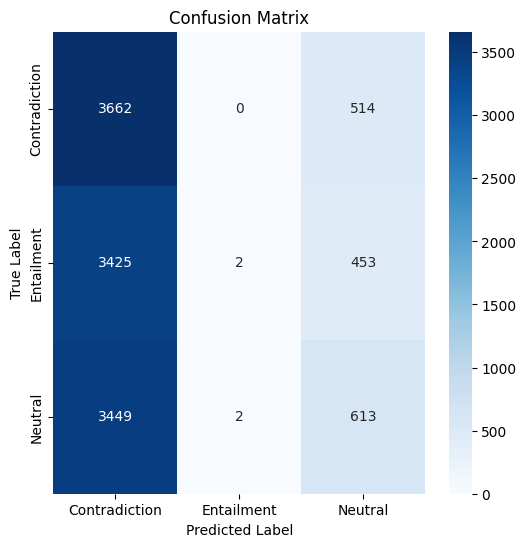

In [75]:
# Call function
plot_confusion_matrix(model, dataloader)

**Plot AUC-ROC Curve**

In [76]:
from sklearn.metrics import roc_curve, auc

In [77]:
def plot_roc_curve(model, dataloader, num_classes=3):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            all_preds.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # One-hot encode labels
    all_labels = np.eye(num_classes)[all_labels]

    plt.figure(figsize=(8,6))

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(all_labels[:, i], all_preds[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("AUC-ROC Curve")
    plt.legend()
    plt.show()

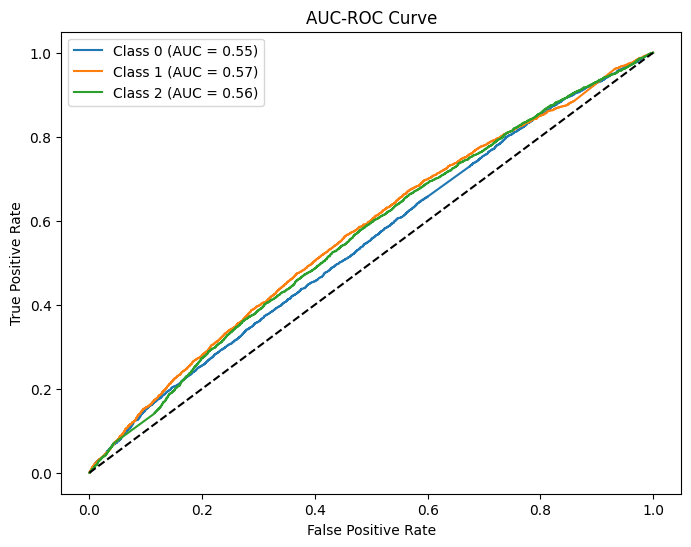

In [78]:
# Call function
plot_roc_curve(model, dataloader)